# Import the Libraries

In [13]:
#Import all required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
from skimage.filters import threshold_otsu, threshold_multiotsu
from sklearn.cluster import KMeans
import cv2
import time
from collections import deque
from mpl_toolkits.mplot3d import Axes3D


# Image Preprocessing

In [14]:
# Load the Data
data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']

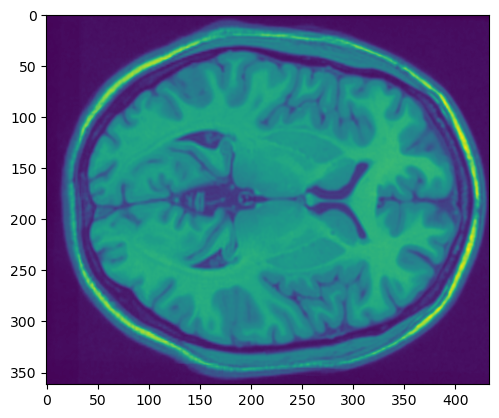

In [15]:
plt.imshow(T1[:,:,0])

# Defining common functions for some algo

Comparision of Segmented Image with Original and Ground Truth Images

In [16]:
# Display segmentation result to be compared
def display_compared_images(t1_image, ground_truth, segmented_image, segmented_image_title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    # Show T1 Image
    image1 = ax1.imshow(t1_image)
    fig.colorbar(image1, ax=ax1, location='bottom',pad=0.01)
    ax1.set_title('Original T1 Image', fontsize=15)
    ax1.axis('off')
    # Show Label Image with Colorbar
    image2 = ax2.imshow(ground_truth)
    fig.colorbar(image2, ax=ax2, location='bottom',pad=0.01)
    ax2.set_title('Label Image', fontsize=15)
    ax2.axis('off')
    # Show Segmented Image Slice
    image3 = ax3.imshow(segmented_image)
    fig.colorbar(image3, ax=ax3, location='bottom', pad=0.01)
    ax3.set_title(segmented_image_title, fontsize=15)
    ax3.axis('off')
    plt.show()

Image Evaluation Metrics

In [17]:
def image_evaluation_metrics(image, ground_truth, tm, print_metrics=True):
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum(image & ground_truth)
    FP = np.sum(image & (~ground_truth))
    FN = np.sum((~image) & ground_truth)
    TN = np.sum((~image) & ground_truth)

    dice_coefficient = 2 * TP / (2 * TP + FP + FN) # Calculate Dice coefficient
    jaccard_index = TP / (TP + FP + FN)# Calculate Jaccard index
    pixel_accuracy = (TP + TN) / (TP + FP + TN + FN)# Calculate pixel accuracy
    sensitivity = TP / (TP + FN)# Calculate Sensitivity
    specificity = TN / (TN + FP)# Calculate Specificity

    if print_metrics:
      print(f"Dice coefficient: {dice_coefficient}", f"Jaccard index: {jaccard_index}",
            f"Pixel accuracy: {pixel_accuracy}", f"Sensitivity: {sensitivity}",
            f"Specificity: {specificity}", f"Computation Time: {tm}", sep='\n')
    return dice_coefficient, jaccard_index, pixel_accuracy, sensitivity, specificity, tm

# Task 1: 2D Tissue Segmentation

Function definition for different Image Segmentation Algorithms

In [18]:
# K-Mean Image Segmentation with default 5 clusters
def kmeans_segmentation(image, k_clusters = 5):
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    reshaped_image = np.reshape(image, (-1, 1))
    kmeans = KMeans(n_clusters=k_clusters, random_state=0, max_iter = 50, n_init=10)
    kmeans.fit(reshaped_image)
    segmented_image = np.reshape(kmeans.labels_, image.shape)
    return segmented_image
# Otsu Image Segmentation, auto thresholding
def otsu_segmentation(image):
    threshold = threshold_otsu(image)
    segmented_image = image > threshold
    return segmented_image
# Multi Otsu Segmentation
def multi_otsu_segmentation(image, region):
  image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  thresholds = threshold_multiotsu(image, classes=region)
  # Using the threshold values, we generate the three regions.
  regions = np.digitize(image, bins=thresholds)
  return regions
# Adaptive Mean Thresholding
def adaptive_threshold_mean(image):
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    image = image.astype('uint8')
    thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    return thresholded_image
# Generalised function to process image segmentation according to required algorithm, default is K-Mean
def segment_images(img_array, algo="kmeans", print_overall_metric = False ,k_clusters = 5):
  segmentation_result = []
  jaccard_indexes = []
  dice_coefficients = []
  pixel_accuracies = []
  sensitivities = []
  specificities = []
  times = []
  for i in range(10):
      t1 = time.monotonic()
      if algo == "kmeans":
        segmented_image = kmeans_segmentation(img_array[:,:,i], k_clusters)
        title = "K-Means " + str(k_clusters)+ " Clusters"
      elif algo == 'otsu':
        segmented_image = otsu_segmentation(img_array[:,:,i])
        title = "Otsu's Segmentation"
      elif algo == 'multi_otsu':
        segmented_image = multi_otsu_segmentation(img_array[:,:,i], k_clusters)
        title = "Multi Otsu Segmentation"
      elif algo == 'adaptive_threshold_mean':
        segmented_image = adaptive_threshold_mean(img_array[:,:,i])
        title = "Adaptive Mean Segmentation"

      display_compared_images(T1[:,:,i], label[:,:,i], segmented_image, title)
      print('Slice '+ str(i) + ' Image')
      segmentation_result.append(segmented_image)
      ji, dc, pa, se, sp, tm = image_evaluation_metrics(segmented_image, label[:,:,i], time.monotonic_ns() - t1)
      # Append results in metric array to calculate overall metric for each image
      jaccard_indexes.append(ji)
      dice_coefficients.append(dc)
      pixel_accuracies.append(pa)
      sensitivities.append(se)
      specificities.append(sp)
      times.append(tm)
  
  overall_metric = {
      'Dice Coefficient': np.mean(dice_coefficients),
      'Jaccard Index': np.mean(jaccard_indexes),
      'Pixel Accuracy': np.mean(pixel_accuracies),
      'Sensitivity': np.mean(sensitivities),
      'Specificity': np.mean(specificities),
      'Computation Time': np.mean(times)
  }
  if print_overall_metric:
    print(f"------ Overall Metrics ------", f"Dice Coefficient: {overall_metric['Dice Coefficient']}",
          f"Jaccard Index: {overall_metric['Jaccard Index']}", f"Pixel Accuracy: {overall_metric['Pixel Accuracy']}",
          f"Sensitivity: {overall_metric['Sensitivity']}", f"Specificity: {overall_metric['Specificity']}",
          f"Computation Time: {overall_metric['Computation Time']}",sep='\n')

  return segmentation_result, overall_metric


Algorithm for Region Growing Image Segmentaton

In [19]:
# Image segmentation using Region Growing Algo
def region_growing(image, seed_point, threshold):
    image =  cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    mask = np.zeros_like(image, dtype=np.uint8)
    intensity_value = 255
    seed_points = [seed_point]
    while seed_points:
        current_point = seed_points.pop(0)
        if (0 <= current_point[0] < image.shape[0]) and (0 <= current_point[1] < image.shape[1]):
            if mask[current_point] == 0:
                if abs(int(image[current_point]) - int(image[seed_point])) < threshold:
                    mask[current_point] = intensity_value
                    # Add the 4 connected neighboring pixels to the seed points list
                    seed_points.append((current_point[0] + 1, current_point[1]))
                    seed_points.append((current_point[0] - 1, current_point[1]))
                    seed_points.append((current_point[0], current_point[1] + 1))
                    seed_points.append((current_point[0], current_point[1] - 1))

    return mask

# Merge images generated by region growing algorithm
def merge_images(img_array, intensity_arr):
  merged_image = np.zeros_like(img_array[0])
  alias_img = img_array
  for i in range(len(img_array)):
    alias_img[i] = np.where(alias_img[i] < 255, alias_img[i], intensity_arr[i])
    merged_image = np.maximum(merged_image, alias_img[i])
  return merged_image

# Customised algorithm to refine the specific CSF later
def csf_refining(target, ar2, ar3, ar4, ar5, ar6):
  new_arr = np.zeros_like(target)
  rows, columns = target.shape
  for r in range(rows):
    for c in range(columns):
      if ar2[r][c] > 0 or ar3[r][c] > 0 or ar4[r][c] > 0 or ar5[r][c] > 0 or ar6[r][c] > 0:
        new_arr[r][c] = 0
      else:
        new_arr[r][c] = target[r][c]
  return new_arr

Evalution Metric for Segmentation using Region Growing

In [20]:
# Evalution metrics for Images segmented using Region Growing
def image_evaluation_metrics_for_region_growing(image_array, comp_time, print_per_slice_metric=False, print_overall_metric=True):
  jaccard_indexes = []
  dice_coefficients = []
  pixel_accuracies = []
  sensitivities = []
  specificities = []
  times = []
  for i in range(len(image_array)):
    img = image_array[i]
    ji = []
    dc = []
    pa = []
    se = []
    sp = []
    tm = []
    for j in range(len(img)):
      img_label = img[j]
      dice_coefficient, jaccard_index, pixel_accuracy, sensitivity, specificity, comp = image_evaluation_metrics(img_label, label[:,:,i]==j, comp_time[i],print_metrics = False)
      dc.append(dice_coefficient)
      ji.append(jaccard_index)
      pa.append(pixel_accuracy)
      se.append(sensitivity)
      sp.append(specificity)
      tm.append(comp)
    jaccard_indexes.append(ji)
    dice_coefficients.append(dc)
    pixel_accuracies.append(pa)
    sensitivities.append(se)
    specificities.append(sp)
    times.append(tm)
    if print_per_slice_metric:
      print(f"------ Slice {i} ------", f"Dice Coefficient: {np.mean(dc)}", f"Jaccard Index: {np.mean(ji)}",
            f"Pixel Accuracy: {np.mean(pa)}", f"Sensitivity: {np.mean(se)}", f"Specificity: {np.mean(sp)}",
            f"Computation Time: {np.mean(tm)}",sep='\n')

  if print_overall_metric:
    print(f"------ Overall Metrics ------", f"Dice Coefficient: {np.mean(dice_coefficients)}",
          f"Jaccard Index: {np.mean(jaccard_indexes)}", f"Pixel Accuracy: {np.mean(pixel_accuracies)}",
          f"Sensitivity: {np.mean(sensitivities)}", f"Specificity: {np.mean(specificities)}",
          f"Computation Time: {np.mean(comp_time)}",sep='\n')

Image Segmentation using Otsu method

In [ ]:
# Function call
result_otsu_segmentation, overall_metric_otsu = segment_images(T1, "otsu")

Image Segmentation using Multi Otsu

In [ ]:
#Function call
result_multi_otsu, overall_metric_multi_otsu = segment_images(T1, 'multi_otsu', 5)

Image Segmentation using KMeans Clustering

In [ ]:
# Function call
#result_kmeans_segmentation, overall_metric_kmean  = segment_images(T1, "kmeans")

Image Segmentation using Adaptive Mean thresholding

In [ ]:
# Function call
result_adaptive_threshold_mean, overall_metric_adaptive = segment_images(T1, "adaptive_threshold_mean")

Image Segmentation using Region Growing

In [ ]:
segmented_image_array = []
brain_array = []
# Seed points for Air, Skin/Scalp, Skull, CSF, Grey Matter, White MAtter in form of (y,x)
seed_points = [(50, 50), (70, 70), (80, 80), (180, 280), (160, 200), (120, 120)]
# Threshold for Air, Skin/Scalp, Skull, CSF, Grey Matter, White MAtter
thresh_array = [70, 150, 33, 66, 25, 30]
overall_computation_time = []
for i in range(10):
  t1 = time.monotonic_ns()
  image = T1[:, :, i]
  # Apply Region Growing to the segments
  # Air
  image_segmented1 = region_growing(image,seed_points[0], thresh_array[0])
  # Skin / Scalp
  image_segmented2 = region_growing(image,seed_points[1], thresh_array[1])
  # Skull
  image_segmented3 = region_growing(image,seed_points[2], thresh_array[2])
  # CSF
  image_segmented4 = region_growing(image, seed_points[3], thresh_array[3])
  # Grey Matter
  image_segmented5 = region_growing(image, seed_points[4], thresh_array[4])
  #White matter
  image_segmented6 = region_growing(image, seed_points[5], thresh_array[5])

  overall_computation_time.append(time.monotonic_ns() - t1)

  # image minimizations
  seg_1 = image_segmented1
  seg_2 = image_segmented2
  seg_3 = image_segmented3
  seg_4 = csf_refining(image_segmented4, image_segmented1, image_segmented2, image_segmented3, image_segmented5, image_segmented6)
  seg_5 = image_segmented5
  seg_6 = image_segmented6
  segmented_image_array.append([seg_1, seg_2, seg_3, seg_4, seg_5, seg_6])

  # Create subplots for visualisation
  fig, axes = plt.subplots(2, 7, figsize=(15, 5))
  for ind in range(6):
    # Display segmented images according to labels
    axes[0][ind].imshow(segmented_image_array[i][ind])
    axes[0][ind].set_title('Image Segment '+str(ind+1))
    axes[0][ind].axis('off')

    axes[1][ind].imshow(label[:,:,i]==ind)
    axes[1][ind].set_title('Image Labeled '+str(ind+1))
    axes[1][ind].axis('off')

  # Display the combined image with complete labeled image
  combined_image = merge_images([ seg_1, seg_2, seg_3, seg_4, seg_5, seg_6], [0, 40, 80, 120, 160, 200])
  axes[0][6].imshow(combined_image)
  axes[0][6].set_title('Image Merged')
  axes[0][6].axis('off')
  fig.suptitle("Slice "+str(i))

  axes[1][6].imshow(label[:,:,i])
  axes[1][6].set_title('Image Labeled')
  axes[1][6].axis('off')
  # Show the plot
  plt.show()

# Task 2: Result Evaluation

In [ ]:
# Overall mean evaluation metric for Otsu method image segmentation
print(f"------ Overall Metrics, Otsu Method ------", f"Dice Coefficient: {overall_metric_otsu['Dice Coefficient']}",
          f"Jaccard Index: {overall_metric_otsu['Jaccard Index']}", f"Pixel Accuracy: {overall_metric_otsu['Pixel Accuracy']}",
          f"Sensitivity: {overall_metric_otsu['Sensitivity']}", f"Specificity: {overall_metric_otsu['Specificity']}",
          f"Computation Time: {overall_metric_otsu['Computation Time']}",sep='\n')

In [ ]:
# Overall mean evaluation metric for Multi Otsu method image segmentation
print(f"------ Overall Metrics,  Multi Otsu------", f"Dice Coefficient: {overall_metric_multi_otsu['Dice Coefficient']}",
          f"Jaccard Index: {overall_metric_multi_otsu['Jaccard Index']}", f"Pixel Accuracy: {overall_metric_multi_otsu['Pixel Accuracy']}",
          f"Sensitivity: {overall_metric_multi_otsu['Sensitivity']}", f"Specificity: {overall_metric_multi_otsu['Specificity']}",
          f"Computation Time: {overall_metric_multi_otsu['Computation Time']}",sep='\n')

In [ ]:
# Overall mean evaluation metric for K-Mean Clustering
print(f"------ Overall Metrics,  K-Mean------", f"Dice Coefficient: {overall_metric_kmean['Dice Coefficient']}",
          f"Jaccard Index: {overall_metric_kmean['Jaccard Index']}", f"Pixel Accuracy: {overall_metric_kmean['Pixel Accuracy']}",
          f"Sensitivity: {overall_metric_kmean['Sensitivity']}", f"Specificity: {overall_metric_kmean['Specificity']}",
          f"Computation Time: {overall_metric_kmean['Computation Time']}",sep='\n')

In [ ]:
# Overall mean evaluation metric for Adaptive Mean method image segmentation
print(f"------ Overall Metrics,  Adaptive Mean------", f"Dice Coefficient: {overall_metric_adaptive['Dice Coefficient']}",
          f"Jaccard Index: {overall_metric_adaptive['Jaccard Index']}", f"Pixel Accuracy: {overall_metric_adaptive['Pixel Accuracy']}",
          f"Sensitivity: {overall_metric_adaptive['Sensitivity']}", f"Specificity: {overall_metric_adaptive['Specificity']}",
          f"Computation Time: {overall_metric_adaptive['Computation Time']}",sep='\n')

In [ ]:
# Evaluation metric for Adaptive Mean method image segmentation
print(f"------ Overall Metrics,  Adaptive Mean------", f"Dice Coefficient: {overall_metric_adaptive['Dice Coefficient']}",
          f"Jaccard Index: {overall_metric_adaptive['Jaccard Index']}", f"Pixel Accuracy: {overall_metric_adaptive['Pixel Accuracy']}",
          f"Sensitivity: {overall_metric_adaptive['Sensitivity']}", f"Specificity: {overall_metric_adaptive['Specificity']}",
          f"Computation Time: {overall_metric_adaptive['Computation Time']}",sep='\n')
image_evaluation_metrics_for_region_growing(segmented_image_array,overall_computation_time,False, True)

# Task 3: Advanced 2D Tissue Segmentation / 3D Image Segmentation

In [21]:
# Function definition for 3D/Advanced 2D Segmentation
def region_growing_advanced_segmentation(image, seed_point, threshold):
    segmented = np.zeros_like(image, dtype=np.uint8)
    # Initializing deque with seed point
    queue = deque([seed_point])
    while queue:
        current_point = queue.popleft()
        x, y, z = current_point
        # Check if current point is within image bounds
        if (0 <= x < image.shape[0] and
            0 <= y < image.shape[1] and
            0 <= z < image.shape[2] and
            segmented[x, y, z] == 0):  # Check if point is unprocessed
            # Check if intensity is below threshold
            if abs(image[x, y, z] - image[seed_point]) < threshold:
                # Assign value 1 to segmented region
                segmented[x, y, z] = 1
                # Enqueue neighboring points
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        for k in range(-1, 2):
                            queue.append((x + i, y + j, z + k))

    return segmented
# Function to plot Advanced Segmented Images
def plot_advanced_segmentation(segmented, region, top_view=False):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    # Extract coordinates of segmented points
    x, y, z = np.nonzero(segmented)
    # Plot segmented points
    ax.scatter(x, y, z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if top_view:
        ax.view_init(azim=0, elev=90)
    text = 'MRI: 3D Visualization, Segmented Regions is - '+str(region)
    plt.title(text)
    plt.show()

# Function to visualise all segmented regions in single view
def plot_advanced_segmentation_single_view(top_view=False):
    segment_name = ['Air', 'Skin/Scalp', 'Skull', 'CSF', 'Grey Matter', 'White Matter']
    fig = plt.figure(figsize=(15, 10))
    # Plot images in the first row
    for i, img in enumerate([brain_array[0], brain_array[1], brain_array[2]]):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        x, y, z = np.nonzero(img)
        ax.scatter(x, y, z, color='r',alpha=0.8)
        ax.set_title(f'Image {segment_name[i]}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        if top_view:
            ax.view_init(azim=0, elev=90)
    # Plot images in the second row
    for i, img in enumerate([brain_array[3], brain_array[4], brain_array[5]]):
        ax = fig.add_subplot(2, 3, i+4, projection='3d')
        x, y, z = np.nonzero(img)
        ax.scatter(x, y, z,color='r',alpha=0.9)
        ax.set_title(f'Image {segment_name[i+3]}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        if top_view:
            ax.view_init(azim=0, elev=90)
    plt.tight_layout()
    plt.show()

# Function to evaluate metric for Advanced Segmented Images
def evaluation_metrics_advanced_segmentation(brain_array, comp_time,print_metric_per_section=False, print_metrics_overall=True):
  jaccard_indexes = []
  dice_coefficients = []
  pixel_accuracies = []
  sensitivities = []
  specificities = []
  for i in range(len(brain_array)):
    ji = []
    dc = []
    pa = []
    se = []
    sp = []
    section_array = brain_array[i]
    for j in range(10):
      slice_image = section_array[:,:,j]
      dice_coefficient, jaccard_index, pixel_accuracy, sensitivity, specificity, tm = image_evaluation_metrics(slice_image, label[:,:,j]==i, comp_time[i],print_metrics = False)
      dc.append(dice_coefficient)
      ji.append(jaccard_index)
      pa.append(pixel_accuracy)
      se.append(sensitivity)
      sp.append(specificity)
    jaccard_indexes.append(ji)
    dice_coefficients.append(dc)
    pixel_accuracies.append(pa)
    sensitivities.append(se)
    specificities.append(sp)
    if print_metric_per_section:
        print(f"----- Section {i} -----", f"Dice Coefficient: {np.mean(dc)}", f"Jaccard Index: {np.mean(ji)}",
              f"Pixel Accuracy: {np.mean(pa)}", f"Sensitivity: {np.mean(se)}", f"Specificity: {np.mean(sp)}",
              f"Computation Time: {comp_time[i]}",sep='\n')

  if print_metrics_overall:
    print(f"------ Overall Metrics ------", f"Dice Coefficient: {np.mean(dice_coefficients)}",
        f"Jaccard Index: {np.mean(jaccard_indexes)}", f"Pixel Accuracy: {np.mean(pixel_accuracies)}",
        f"Sensitivity: {np.mean(sensitivities)}", f"Specificity: {np.mean(specificities)}",
        f"Computation Time: {np.mean(comp_time)}",sep='\n')


In [22]:
T1_data =  cv2.normalize(T1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
brain_array = []
segment_name = ['Air', 'Skin/Scalp', 'Skull', 'CSF', 'Grey Matter', 'White Matter']
# Seed points for Air, Skin/Scalp, Skull, CSF, Grey Matter, White MAtter
seed_points = [(50, 50, 0), (70, 70, 0), (80, 80, 0), (180, 280, 0), (160, 200, 0), (120, 120, 0)]
# Threshold for Air, Skin/Scalp, Skull, CSF, Grey Matter, White MAtter
thresh_array = [70, 150, 33, 50, 25, 30]
comp_time = []
for i in range(6):
    t1 = time.monotonic_ns()
    brain_array.append(region_growing_advanced_segmentation(T1_data,seed_points[i], thresh_array[i]))
    comp_time.append(time.monotonic_ns()-t1)
# Show evaluations for advanced segmented images
evaluation_metrics_advanced_segmentation(brain_array, comp_time, True)

----- Section 0 -----
Dice Coefficient: 0.9562540550617113
Jaccard Index: 0.9161768430879318
Pixel Accuracy: 0.916183073680422
Sensitivity: 0.999918176737674
Specificity: 0.0009040641523443699
Computation Time: 43109443345
----- Section 1 -----
Dice Coefficient: 0.9548017488608801
Jaccard Index: 0.9135189656248179
Pixel Accuracy: 0.9202874937043554
Sensitivity: 0.9150813185608732
Specificity: 0.9801357616786355
Computation Time: 20204828111
----- Section 2 -----
Dice Coefficient: 0.8500970050231139
Jaccard Index: 0.7392950117141486
Pixel Accuracy: 0.7392950117141486
Sensitivity: 1.0
Specificity: 0.0
Computation Time: 12718261639
----- Section 3 -----
Dice Coefficient: 0.49739890489306493
Jaccard Index: 0.3311229255017495
Pixel Accuracy: 0.35511579792687414
Sensitivity: 0.8988756238038716
Specificity: 0.05544501352553475
Computation Time: 27567503279
----- Section 4 -----
Dice Coefficient: 0.8677616623557091
Jaccard Index: 0.7664629772671432
Pixel Accuracy: 0.7794644193757109
Sensitivit

In [ ]:
# Function call to visualize each region of segmented image from region growing 3D algorithm
for segment in range(len(brain_array)):
  plot_advanced_segmentation(brain_array[segment], segment_name[segment], True)

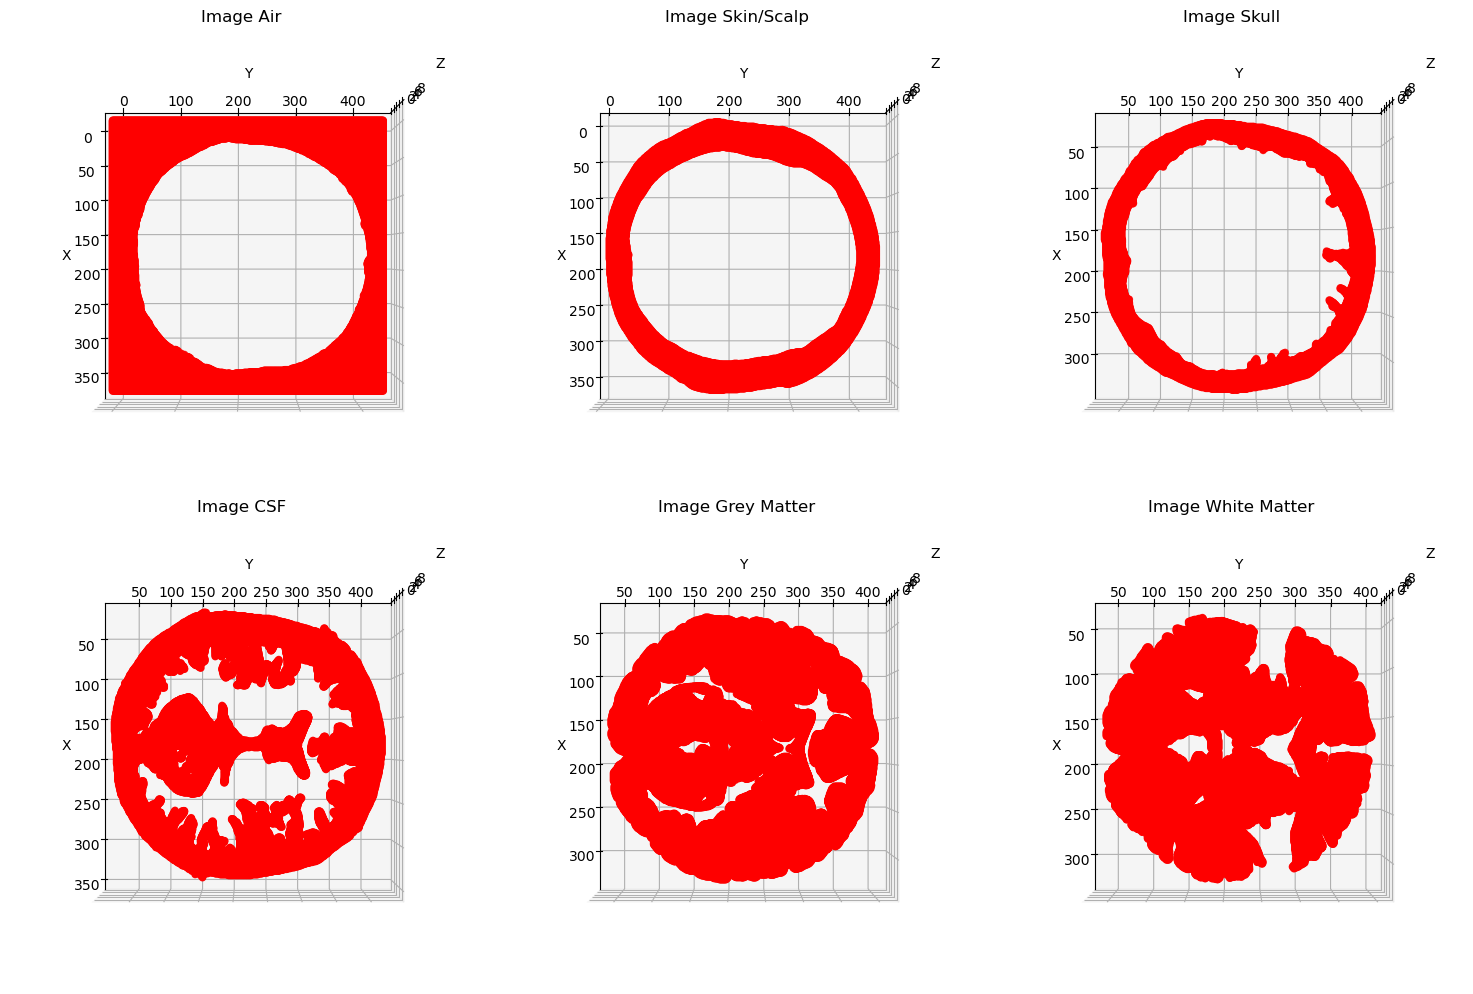

In [10]:
# Function call to visualise 3D images in single view
plot_advanced_segmentation_single_view(True)

In [23]:
from mayavi import mlab

def show_mayavi_3d_image(segmented_array):
    fig = mlab.figure(bgcolor=(1, 1, 1), size=(800, 600))
    # Create a 3D scalar field (volume) from the segmented image
    src = mlab.pipeline.scalar_field(segmented_array)
    # Extract the boundary surface of the segmented region
    surf = mlab.pipeline.iso_surface(src, contours=[1], color=(1, 0, 0))
    surf.actor.property.opacity = 0.8 
    surf.actor.property.frontface_culling = True 
    # Add axes and orientation axes
    mlab.axes()
    mlab.orientation_axes()
    mlab.show()

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



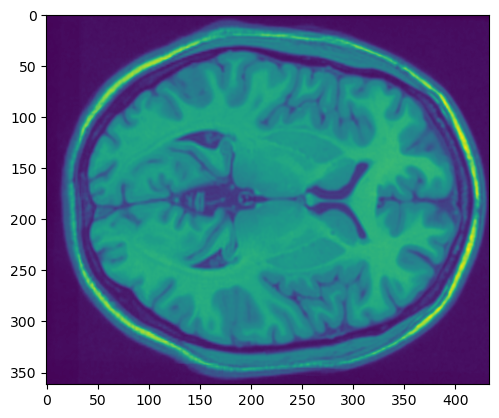

In [13]:
plt.imshow(T1[:,:,0])

In [24]:
for section in brain_array:
    show_mayavi_3d_image(section)

qt.qpa.window: <QNSWindow: 0x7fca5035ed40; contentView=<QNSView: 0x7fca5035e9a0; QCocoaWindow(0x7fca5035e890, window=QWidgetWindow(0x7fca5035e440, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.
qt.qpa.window: <QNSWindow: 0x7fca330b4d30; contentView=<QNSView: 0x7fca3306d130; QCocoaWindow(0x7fca3306e890, window=QWidgetWindow(0x7fca3306e3e0, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.
qt.qpa.window: <QNSWindow: 0x7fca506819e0; contentView=<QNSView: 0x7fca5067edc0; QCocoaWindow(0x7fca50682060, window=QWidgetWindow(0x7fca5067e6c0, name="QMainWindowClassWindow"))>> has active key-value observer

: 